# General setup

In [0]:
# first set whether this notebook is being run by you or by Elsevier supporters
permissions='default' # default or fulldata (default if by you)
# set the project name
project_name = '2806_network_analysis'

In [0]:
%run /Snippets/header_latest

Running the header notebook for project `2806_network_analysis` with level `default`

# Create network

## Load datasets

We first again load the data.

In [0]:
df_ani = spark.read.format("parquet").load(basePath+tablename_ani) # Table of publications
df_apr = spark.read.format("parquet").load(basePath+tablename_apr) # Table of authors
df_asjc = table('static_data.asjc')                                # Table of all ASJC
df_asjc_27 = table('static_data.asjc_27')                          # Table of all ASJC27
df_gender = spark.read.format("parquet").load(basePath+tablename_gender_inference) # Table of gender

We are interested in co-authorship in the social science. Let us see what ASJC27 code corresponds to the social sciences.

In [0]:
display(df_asjc_27)

ASJC27,ASJC_name
10,Multidisciplinary
11,General Agricultural and Biological Sciences
12,General Arts and Humanities
13,"General Biochemistry,Genetics and Molecular Biology"
14,"General Business,Management and Accounting"
15,General Chemical Engineering
16,General Chemistry
17,General Computer Science
18,General Decision Sciences
19,General Earth and Planetary Sciences


Let us first select the publications that we are interested in.

In [0]:
df_pub = (
  df_ani
  .filter('Year BETWEEN 2000 AND 2020')                       # Limit to year 2010--2015  
  .select('eid', 'Au', func.explode('ASJC').alias('ASJC'))    # Get all ASJC codes
  .filter(func.substring('ASJC', 1, 2) == "33")               # Limit to social sciences
  .filter(func.size('Au') > 1)                                # Limit to publications with multiple authors  
  .select('eid', 'Au')                                        # Get authors
  .distinct()                                                 # And make them unique  
)

Now let us establish co-authorship again. 
We already aggregate the duplicate number of links, to create a weight.

In [0]:
df_co_au = (
  df_pub
  .withColumn('weight', 1/(func.size('Au') - 1))      # Calculate fractional weight  
  .select('Au', 'weight', func.explode('Au').alias('Au_A'))     # Get list of all authors
  .select('Au_A', 'weight', func.explode('Au').alias('Au_B'))   # Get pair of all authors
  .select(func.col('Au_A.auid').alias('auid_A'),      # Call one author of pair auid_A
          func.col('Au_B.auid').alias('auid_B'),      # Call other author of pair auid_B
         'weight')
  .filter('auid_A < auid_B')                          # Only retain one of the two pairs, e.g. only (1, 3) not (3, 1)  
  .groupby('auid_A', 'auid_B')
  .agg(func.sum('weight').alias('weight'))            # And sum all the weights
)

We add some information to the authors.

In [0]:
df_uniq_au = (
  df_co_au
  .select(func.col('auid_A').alias('auid'))
  .union(df_co_au.select(func.col('auid_B').alias('auid')))
  .distinct()
)

df_uniq_au = (
  df_uniq_au
  .join( (df_apr
          .select('auid', func.struct('given_name_pn', 'initials_pn', 'surname_pn', 'indexed_name_pn').alias('name'),
                      func.col('affiliation_current_full')[0].alias('affiliation'))
         )
        ,on='auid'
        ,how='left')
  .join((
          df_pub
          .join(df_ani.select('eid', 'ASJC'), on='eid')
          .select('eid', func.explode('ASJC').alias('ASJC'), 'Au')
          .select('eid', 'ASJC', func.explode('Au').alias('Au'))
          .groupby('Au.auid', 'ASJC')
          .count()
          .withColumn('row', (func.row_number()
                              .over(Window
                                    .partitionBy('auid')
                                    .orderBy(func.col('count').desc())
                                   )
                             )
                     )
          .filter('row == 1')
          .drop('row')
          .join(df_asjc, on='ASJC')
        ),
        on='auid', how='left'
  )
  .join(df_gender, on='auid', how='left')
  .orderBy('auid')
)

Let us take a look at the ASJC categories of these publications.

In [0]:
display(
  df_uniq_au
  .groupby('ASJC_name', 'ASJC')
  .count()
)

ASJC_name,ASJC,count
Fluid Flow and Transfer Processes,1507,5
Nutrition and Dietetics,2916,49
"General Business,Management and Accounting",1400,285
Nature and Landscape Conservation,2309,328
Chemical Health and Safety,1504,45
Sociology and Political Science,3312,3996
Museology,1209,23
Environmental Engineering,2305,142
Building and Construction,2215,139
General Decision Sciences,1800,19


As you can see, not all publications belong to ASJC that starts with 33, i.e. not all publications belong to ASJC27, "General Social Sciences".

**❓ Do you have any idea why there are also publications outside of the "General Social Sciences"?**

Let us quickly see how many nodes and edges we expect in our network.

In [0]:
print(df_uniq_au.count())
print(df_co_au.count())

73901
187723

## Create network

We first import the `igraph` library.

In [0]:
import igraph as ig

We now construct the network.

In [0]:
G_coauthorship = ig.Graph.DataFrame(edges=df_co_au.toPandas(),
                       vertices=(df_uniq_au.select('auid', func.col('name.*'), 
                                                   func.col('affiliation.afdispname'), 
                                                   func.col('affiliation.city'), 
                                                   func.col('affiliation.country'), 
                                                   'ASJC',
                                                   'ASJC_name',
                                                   func.col('Inferred_Probable_Gender').alias('gender')
                                                  )
                                .toPandas()
                                ),
                       directed=False
                      )

# Analysis

## Centrality

Let us focus on the giant component for now.

In [0]:
components = G_coauthorship.components()
H = components.giant()

There are various measures of centrality that you can use.
The simplest one, the degree, does not even require a network perspective.
It simply corresponds to the total number of (distinct) collaborators that one had.
When counting fully, the sum of all these collaborations is simply equal to the total number of collaborations.
When counting fractionally, the sum of all these collaborations is simply equal to the number of papers.

In [0]:
H.vs['degree'] = H.degree()
H.vs['strength'] = H.strength(weights='weight')

**❓ Can you get the strength and degree for `'Opre A.'`? How many collaborators did he have, and how many papers did he publish?**

In [0]:
v = H.vs.find(indexed_name_pn_eq = 'Opre A.')
H.vs[v.index]

Out[18]: igraph.Vertex(<igraph.Graph object at 0x7f86cbf12400>, 0, {'name': 6503877579, 'given_name_pn': 'Adrian Nicolae', 'initials_pn': 'A.N.', 'surname_pn': 'Opre', 'indexed_name_pn': 'Opre A.', 'afdispname': 'Universitatea Babeș-Bolyai, Department of Psychology', 'city': 'Cluj Napoca', 'country': 'Romania', 'ASJC': '3207', 'ASJC_name': 'Social Psychology', 'gender': 'male', 'degree': 134, 'strength': 2.000000000000001})

There are also more sophisticated centrality measures, such as pagerank.
In pagerank, the idea is roughly that a node is central if its neighbours are central.
If a connection has a higher weight, then the centrality of that neighbour is weighted even more strongly.
Strong connections to central node increase centrality, in a sense.

In [0]:
H.vs['pagerank'] = H.pagerank()
H.vs['pagerank_weighted'] = H.pagerank(weights='weight')

Let us look at the pagerank results and compare them to the weighted pagerank.
We can get all vertex attributes in a convenient `pandas` dataframe through the function `get_vertex_dataframe`.
This then lists all nodes and all attributes of all nodes, and we can easily use this for plotting.

Out[20]:

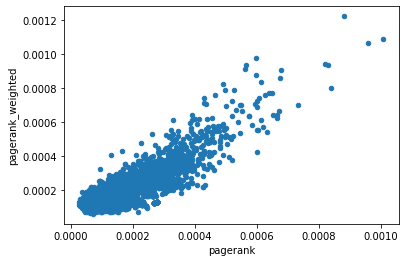

<AxesSubplot:xlabel='pagerank', ylabel='pagerank_weighted'>

In [0]:
vertex_df = H.get_vertex_dataframe()
vertex_df.plot('pagerank', 'pagerank_weighted', kind='scatter')

Let us look at the nodes with the highest weighted pagerank centrality.

In [0]:
(
  vertex_df
  .sort_values('pagerank_weighted', ascending=False)
  .head(10)
)

Out[21]:

,name,given_name_pn,initials_pn,surname_pn,indexed_name_pn,afdispname,city,country,ASJC,ASJC_name,gender,degree,strength,pagerank,pagerank_weighted
vertex ID,,,,,,,,,,,,,,,
1639,7201585638,Herbert W.,H.W.,Marsh,Marsh H.,Australian Catholic University,"North Sydney, NSW",Australia,3304,Education,male,36,24.000000,0.000880,0.001223
1541,7102620086,E. Tory,E.T.,Higgins,Higgins E.,"Columbia University, Department of Psychology",New York,United States,3312,Sociology and Political Science,None,31,13.000000,0.001008,0.001092
3678,36515607400,Heike,H.,Schroeder,Schroeder H.,"University of East Anglia, School of Internati...",Norwich,United Kingdom,2308,"Management, Monitoring, Policy and Law",female,57,12.000000,0.000958,0.001064
1127,7004755071,Robert,R.,C. Pianta,C. Pianta R.,University of Virginia,Charlottesville,United States,3304,Education,male,29,15.000000,0.000598,0.000974
860,7003498771,Margaret R.,M.R.,Burchinal,Burchinal M.,"University of Virginia, Center for Advanced St...",Charlottesville,United States,3204,Developmental and Educational Psychology,female,42,13.000000,0.000820,0.000939
527,6603141425,Matt,M.,DeLisi,DeLisi M.,Iowa State University,Ames,United States,3308,Law,male,29,13.000000,0.000830,0.000937
753,6701679127,Marian J.,M.J.,Bakermans-Kranenburg,Bakermans-Kranenburg M.,Leiden University,Leiden,Netherlands,3204,Developmental and Educational Psychology,unknown,91,10.985075,0.000564,0.000935
1201,7005398271,Marinus H.,M.H.,van IJzendoorn,van IJzendoorn M.,University College London,London,United Kingdom,3204,Developmental and Educational Psychology,male,88,10.985075,0.000562,0.000913
3944,51565722800,Maria,M.,Brockhaus,Brockhaus M.,Helsingin Yliopisto,Helsinki,Finland,3305,"Geography, Planning and Development",male,39,10.000000,0.000678,0.000905


Now let us consider betweenness centrality.
If there are many shortest paths passing through a certain node, it is said to have a high betweenness centrality.
We can also look at the weighted shortest paths.

In [0]:
H.vs['betweenness'] = H.betweenness()
H.vs['betweenness_weighted'] = H.betweenness(weights='weight')

Remember, shortest paths prefer edges with *lower* weights, not with *higher* weights.
Stronger connections lower the betweenness centrality, in a sense.

Out[23]:

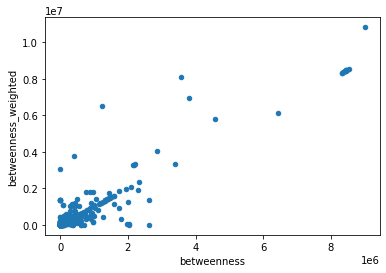

<AxesSubplot:xlabel='betweenness', ylabel='betweenness_weighted'>

In [0]:
vertex_df = H.get_vertex_dataframe()
vertex_df.plot('betweenness', 'betweenness_weighted', kind='scatter')

Now let us look at the node with the highest betweenness centrality.

In [0]:
(
  vertex_df
  .sort_values('betweenness', ascending=False)
  .head(10)
)

Out[24]:

,name,given_name_pn,initials_pn,surname_pn,indexed_name_pn,afdispname,city,country,ASJC,ASJC_name,gender,degree,strength,pagerank,pagerank_weighted,betweenness,betweenness_weighted
vertex ID,,,,,,,,,,,,,,,,,
1141,7004924415,Alex R.,A.R.,Piquero,Piquero A.,University of Miami,Coral Gables,United States,3308,Law,male,20,12.0,0.000674,0.000859,8.997245e+06,10815920.0
1195,7005364475,Mei Po,M.P.,Kwan,Kwan M.,Chinese University of Hong Kong,Shatin,Hong Kong,3305,"Geography, Planning and Development",unknown,9,5.0,0.000339,0.000501,8.543732e+06,8543732.0
3993,54783595500,Ran,R.,Wei,Wei R.,"University of California, Riverside, School of...",Riverside,United States,3305,"Geography, Planning and Development",male,9,3.0,0.000321,0.000301,8.466292e+06,8466292.0
2481,14820100300,Danielle M.,D.M.,Wallace,Wallace D.,School of Criminology and Criminal Justice,Phoenix,United States,3322,Urban Studies,female,9,4.0,0.000345,0.000329,8.462587e+06,8462587.0
4844,56516133200,Matthew J.,M.J.,Larson,Larson M.,"Wayne State University, Department of Criminal...",Detroit,United States,3308,Law,male,6,3.0,0.000216,0.000232,8.460291e+06,8460291.0
372,6602481009,Tony H.,T.H.,Grubesic,Grubesic T.,The University of Texas at Austin,Austin,United States,3322,Urban Studies,male,5,3.0,0.000214,0.000273,8.454969e+06,8456065.0
3503,35726692800,Steven,S.,Farber,Farber S.,"University of Toronto, Department of Human Geo...",Toronto,Canada,3305,"Geography, Planning and Development",male,9,3.0,0.000311,0.000314,8.433773e+06,8433773.0
1336,7006406005,Nicky,N.,Gregson,Gregson N.,Faculty of Social Sciences & Health,Durham,United Kingdom,3305,"Geography, Planning and Development",unknown,6,5.0,0.000210,0.000405,8.429428e+06,8429428.0
420,6602697750,Harriet A.,H.A.,Bulkeley,Bulkeley H.,"Durham University, Department of Geography",Durham,United Kingdom,3305,"Geography, Planning and Development",female,15,9.0,0.000392,0.000641,8.427213e+06,8427215.5


**❓ Do you see any overlap between the highest pagerank and the highest betweenness centrality?**

Let us consider the correlations between the various centrality measures.
As you can see, betweenness and pagerank tend to capture something quite different.
Pagerank seems to be relatively closely associated with the strength of a node, especially in the weighted variant.

In [0]:
vertex_df[['degree',
           'strength',
           'pagerank',
           'pagerank_weighted',
           'betweenness']].corr()

Out[25]:

,degree,strength,pagerank,pagerank_weighted,betweenness
degree,1.000000,0.126296,0.371505,0.191104,0.018902
strength,0.126296,1.000000,0.722112,0.925920,0.243755
pagerank,0.371505,0.722112,1.000000,0.823451,0.226999
pagerank_weighted,0.191104,0.925920,0.823451,1.000000,0.253088
betweenness,0.018902,0.243755,0.226999,0.253088,1.000000


## Clustering coefficient

Let us consider how many neighboours of a node are connected amongst themselves.
This is called clustering, or in the language of `igraph`, transitivity.

In [0]:
H.vs['clustering'] = H.transitivity_local_undirected()

Nodes with a high clustering coefficient are well embedded in their local network, most of their neighbours are also in contact with each other.
This also means that they are not so important in connecting other people, since most of their neighbours are also already connected directly.
On the other hand, nodes that have a lower clustering coefficient, are important in connecting their neighbours.
After all, without that node, its neighbours are at least not connected directly with each other.

This suggests that the clustering coefficient is probably inversely related to centrality. 

**❓ Can you plot `clustering` versus `pagerank` to check whether more central nodes are less clustered?**

Out[27]:

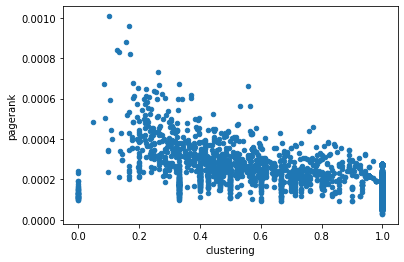

<AxesSubplot:xlabel='clustering', ylabel='pagerank'>

In [0]:
vertex_df = H.get_vertex_dataframe()
vertex_df.plot('clustering', 'pagerank', kind='scatter')

## Homophily

Homophily is the tendency of nodes that share certain characteristics to connect to each other.

Let us take a look at the homophily based on the inferred gender of authors.
We can quantify the strength of the homophily based on the *assortativity*.
In order to use the `assortativity_nominal` function of `igraph`, we need to have numerical labels for the categories (i.e. `0`, `1`, `2` instead of `female`, `male`, `unknown`). We can use a convenience function of `igraph` for that, namely the `UniqueIdGenerator`.

In [0]:
idgen = ig.UniqueIdGenerator()
G_coauthorship.vs['gender_id'] = [idgen[a] for a in G_coauthorship.vs['gender']]
G_coauthorship.assortativity_nominal('gender_id')

Out[28]: 0.13532806359878405

This suggests that women are somewhat more likely to collaborate with women, and men are somewhat more likely to collaborate with men.

**❓ Can you now calculate the assortativity for the research field (`ASJC`)?**

In [0]:
idgen = ig.UniqueIdGenerator()
G_coauthorship.vs['ASJC_id'] = [idgen[a] for a in G_coauthorship.vs['ASJC']]
G_coauthorship.assortativity_nominal('ASJC_id')

Out[29]: 0.3551138000917281

As you can see, there is also substantial assortativity in the research field, as expected.
Let us try to see if there is gender assortativity within each research field.

In order to do so, we can create a *partition* of the network into research fields.

In [0]:
asjc_partition = ig.VertexClustering.FromAttribute(G_coauthorship, 
                                                   attribute='ASJC_id')

You can now access all subgraphs of the ASJC partition easily using `subgraph`. For instance, we can get the subgraph of cluster 0 as follows

In [0]:
H_asjc_0 = asjc_partition.subgraph(0)

We can get all subgraphs using `subgraphs` (note the additional `s`).
This returns a list of all subgraphs.

**❓ Can you now calculate the assortativity within each ASJC research field, i.e. within each subgraph?**

In [0]:
[(cl.assortativity_nominal('gender_id'), cl.vcount()) for cl in asjc_partition.subgraphs()]

Out[32]: [(0.1386019151594789, 1505),
 (0.11193316108794713, 3996),
 (0.0945819810407871, 488),
 (0.09762877377873391, 359),
 (0.08217425081481175, 555),
 (0.1475431319743404, 1233),
 (0.17233384853168474, 204),
 (0.04394294305430847, 1691),
 (0.3073672607018189, 108),
 (0.11193078888554917, 3086),
 (0.010833688868416732, 1195),
 (0.11540798519209827, 8448),
 (0.07055798955301745, 831),
 (0.06857893142106856, 213),
 (0.1591825520601853, 1120),
 (0.10875266096936417, 318),
 (0.035213789220201686, 357),
 (0.010804508356004624, 160),
 (0.05001722904020985, 462),
 (0.058550167723674246, 814),
 (0.13010358756266066, 695),
 (0.1779191111317232, 1470),
 (0.05222787965565811, 598),
 (0.07378108859789818, 569),
 (-0.18727915194346292, 39),
 (-0.06764705882352942, 243),
 (-0.08647892949870185, 96),
 (0.11667478155668079, 4697),
 (-0.04490001257703426, 164),
 (-0.013029120384268993, 88),
 (0.046351718566392565, 791),
 (0.07999064576144177, 2845),
 (0.051401317498170104, 211),
 (0.06184068289409921, 166),
 (0.035377636860826435, 605),
 (0.08006530080079104, 601),
 (0.14916648431883028, 649),
 (0.05287135835031777, 78),
 (0.34545454545454546, 68),
 (0.15314751017851547, 145),
 (0.08529666642476304, 436),
 (0.12589781813253817, 106),
 (0.011952191235059776, 57),
 (0.18524495677233432, 321),
 (0.083138105845303, 568),
 (0.08945539455189833, 1537),
 (0.06351329790498175, 420),
 (-0.03379721669980118, 60),
 (0.19021633209900607, 1190),
 (0.05160887779659507, 310),
 (0.16952447491856362, 1273),
 (0.008934806352844216, 142),
 (0.1550603528319405, 328),
 (0.1616164932208398, 137),
 (0.052970781962506375, 289),
 (0.14710792544774223, 1256),
 (0.3571428571428568, 24),
 (0.29739691315365124, 176),
 (0.09688943451416715, 1520),
 (0.10396681358568828, 68),
 (0.15033310804286953, 208),
 (0.26383456202351124, 325),
 (0.19673184613972278, 834),
 (0.18191356926907348, 774),
 (-0.03457070968186681, 192),
 (0.051028688720225285, 376),
 (0.22846120874410628, 109),
 (0.11780495079033705, 312),
 (0.10842222576022927, 181),
 (0.18300843759092242, 178),
 (0.4385964912280701, 45),
 (0.15108026918182893, 210),
 (0.05476742214435098, 97),
 (-0.07812500000000001, 43),
 (0.14284048280821796, 405),
 (0.1056911501478943, 1536),
 (0.07712119044212319, 122),
 (0.4999999999999999, 42),
 (0.12414473604067097, 435),
 (0.1612009908886067, 1172),
 (0.17148765605453295, 594),
 (0.10562042999017786, 178),
 (0.03947607786065121, 269),
 (-0.07865168539325842, 34),
 (0.1794200672730615, 769),
 (0.1653684076107777, 65),
 (0.14461225074398842, 374),
 (0.368421052631579, 26),
 (0.015384615384615385, 23),
 (0.06461816538635347, 398),
 (0.06878223552108345, 246),
 (0.05279664493777639, 280),
 (-0.3846153846153847, 66),
 (0.1028467959925912, 335),
 (0.005788818055250298, 298),
 (0.09942547079476544, 285),
 (0.04283921849793875, 139),
 (0.22885898276327465, 396),
 (0.19334735379806675, 339),
 (0.12750065291198745, 258),
 (0.1899088997897688, 73),
 (-0.07540173053152047, 74),
 (0.11225927665570695, 213),
 (0.09048699958728865, 498),
 (0.186346098256815, 470),
 (0.24752704344304974, 195),
 (0.20084178476280026, 382),
 (0.23976651671190094, 276),
 (-0.006109979633401163, 71),
 (0.03233694033902824, 221),
 (-1.0, 5),
 (0.10187347211716596, 430),
 (0.21060683324834273, 118),
 (0.17008911274699728, 325),
 (-0.4, 25),
 (0.4856902356902356, 129),
 (0.06723300560134031, 242),
 (-0.01685772083614303, 81),
 (0.06739612134047086, 279),
 (-0.32577903682719567, 72),
 (0.03744786175917869, 311),
 (0.11046273612798843, 233),
 (0.15712988192552232, 141),
 (-0.06432748538011696, 36),
 (-0.019896463543940614, 61),
 (0.07529722589167764, 64),
 (0.11538461538461545, 50),
 (-0.3114754098360656, 15),
 (0.1365556076959174, 49),
 (0.3527508090614888, 47),
 (0.057622709794164194, 345),
 (0.09549489197789321, 155),
 (0.5733333333333335, 95),
 (-0.021848739495798318, 55),
 (0.27777777777777785, 22),
 (0.2912052117263843, 73),
 (0.29869301880777827, 127),
 (0.512014787430684, 77),
 (0.06666666666666665, 12),
 (-0.03

# Clustering

Now let us look at clustering the network.
Clustering only makes sense with a connected network.
After all, if two parts of the network are completely disconnected, they will never be put in the same cluster.
Let us therefore consider the giant component of this co-authorship network.

In [0]:
components = G_coauthorship.components()
H = components.giant()

We will use the `leidenalg` package for clustering networks, which implements the Leiden algorithm
There is also various clustering functionality builtin in `igraph`, among which the Leiden algorithm, available as `community_leiden`.
The `igraph` implementation is less versatile, but it is a bit faster.

In [0]:
import leidenalg as la

If we want to find clusters, we can use the `find_partition` function.
We need to provide it with the type of partition we want to find (e.g. CPM or Modularity), and possibly a resolution parameter.
In this case, we will also use weights for the clustering.
Additionally, we supply a seed for the random number generator to ensure that everybody will get the same result here.

In [0]:
cluster = la.find_partition(H, 
                            la.CPMVertexPartition, 
                            resolution_parameter=0.001, 
                            weights='weight',
                            seed=42)

**❓ Can you now calculate the assortativity of the detected clusters?**

In [0]:
H.assortativity_nominal(cluster.membership)

Out[36]: 0.9068372373663295

We can also compare our clustering to the ASJC clustering.
We can do so using what is called the *Normalised Mutual Information* (NMI).
This varies between 0 and 1, and equals 1 if the two partitions are identical, and 0 if they are completely different.

In [0]:
asjc_partition = ig.VertexClustering.FromAttribute(H, 'ASJC_id')
cluster.compare_to(asjc_partition, 'NMI')

Out[37]: 0.43766850524794143

Let us again creat a vertex dataframe to make it a bit easier to inspect some of the results.

In [0]:
H.vs['cluster'] = cluster.membership
vertex_df = H.get_vertex_dataframe()

**❓ Can you explore some of the clusters to identify what they might have in common?**

In [0]:
(
  vertex_df
  .query('cluster == 2')
  .head(20)
)

Out[39]:

,name,given_name_pn,initials_pn,surname_pn,indexed_name_pn,afdispname,city,country,ASJC,ASJC_name,gender,gender_id,ASJC_id,cluster
vertex ID,,,,,,,,,,,,,,
2,6503954796,Sandra,S.,Quijas,Quijas S.,Universidad de Guadalajara,Guadalajara,Mexico,1101,Agricultural and Biological Sciences (miscella...,female,0,24,2
21,6504391553,Owen,O.,Gaffney,Gaffney O.,"Stockholms universitet, Stockholm Resilience C...",Stockholm,Sweden,2309,Nature and Landscape Conservation,male,3,52,2
37,6505763602,Mark,M.,Stafford-Smith,Stafford-Smith M.,CSIRO Land and Water,Highett VIC,Australia,2308,"Management, Monitoring, Policy and Law",None,2,45,2
47,6505898338,Henrik,H.,Österblom,Österblom H.,Stockholms universitet,Stockholm,Sweden,2303,Ecology,unknown,1,4,2
218,6507862886,Maria Clara,M.C.,Silva-Forsberg,Silva-Forsberg M.,None,None,None,3314,Anthropology,female,0,19,2
228,6507964944,Jonas,J.,Ebbesson,Ebbesson J.,"Stockholms universitet, Department of Law",Stockholm,Sweden,2304,Environmental Chemistry,male,3,33,2
230,6508004334,Sander E.,S.E.,van der Leeuw,van der Leeuw S.,"Arizona State University, Global Futures Labor...",Tempe,United States,2303,Ecology,male,3,4,2
248,6508230751,Fredrik,F.,Moberg,Moberg F.,Stockholms universitet,Stockholm,Sweden,2304,Environmental Chemistry,male,3,33,2
285,6602120712,Frances R.,F.R.,Westley,Westley F.,University of Waterloo,Waterloo,Canada,3321,Public Administration,female,0,46,2


## Term co-occurrence

These clustering techniques can of course be applied to any network.
Let us now focus on a network of terms.
Instead of looking at the co-occurrence of terms, we can look at the bipartite network of documents and terms.
This allows us to cluster both documents and terms simultaneously.

Let us first create a dataframe of publications and keywords.
We will prepend `E-` and `T-` to publications and terms respectively, in order to ensure that we can identify them easily.

In [0]:
df_pub_term = (

  df_pub
  .join(df_ani.select('eid', 'keywords'), on='eid')
  .select('eid', func.explode('keywords').alias('keyword'))
  .select(func.concat(func.lit('E-'), 'eid').alias('eid'), 
          func.concat(func.lit('T-'), 'keyword').alias('keyword')
         )
  .groupby('eid', 'keyword')
  .count()
)

We can now construct the bipartite network, and let us only concentrate on the giant component again.

In [0]:
G_pub_term = ig.Graph.DataFrame(edges=df_pub_term.toPandas(),
                                directed=False)
G_pub_term = G_pub_term.components().giant()

In [0]:
G_pub_term.summary()

Out[42]: 'IGRAPH UN-- 62624 85130 -- \n+ attr: name (v), count (e)'

In order to identify the type of node (whether it is a publication or a term), we create an additional vertex attribute.
We also require this vertex attribute later.

In [0]:
G_pub_term.vs['type'] = [v['name'][0] for v in G_pub_term.vs]

We can now use a particular feature of `leidenalg` that supports clustering bipartite networks.
See the [documentation](https://leidenalg.readthedocs.io/en/stable/multiplex.html#bipartite) for more details, if you are interested.

In [0]:
resolution_parameter=0.0001

# Create three layer partitions that are necessary for bipartite clustering
p_01, p_0, p_1 = la.CPMVertexPartition.Bipartite(G_pub_term, 
                                                 types='type',
                                                 resolution_parameter_01=resolution_parameter);

# Optimise partitions
optimiser = la.Optimiser()
optimiser.set_rng_seed(42)
diff = optimiser.optimise_partition_multiplex([p_01, p_0, p_1],
                                              layer_weights=[1, -1, -1]);

# Call result cluster
cluster = p_01

Now our bipartite clustering results are available in the variable `cluster`, similar as before.

In [0]:
cluster.sizes()

Out[45]: [5186,
 5074,
 3177,
 2466,
 2206,
 1486,
 1326,
 1297,
 1189,
 1010,
 969,
 950,
 945,
 883,
 857,
 840,
 743,
 709,
 699,
 677,
 677,
 650,
 647,
 646,
 645,
 623,
 623,
 609,
 591,
 587,
 577,
 575,
 565,
 549,
 537,
 523,
 510,
 504,
 487,
 486,
 459,
 449,
 439,
 433,
 426,
 414,
 410,
 403,
 401,
 381,
 372,
 369,
 368,
 368,
 360,
 353,
 333,
 327,
 326,
 315,
 314,
 313,
 310,
 302,
 300,
 299,
 298,
 296,
 291,
 287,
 285,
 281,
 281,
 276,
 269,
 264,
 258,
 255,
 234,
 232,
 232,
 225,
 220,
 217,
 209,
 202,
 202,
 193,
 187,
 185,
 181,
 179,
 175,
 169,
 164,
 159,
 157,
 155,
 151,
 142,
 65,
 47,
 31,
 28,
 25,
 23,
 20,
 20,
 19,
 18,
 15,
 15,
 15,
 14,
 14,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5]

Let us store these results as a vertex attribute.

In [0]:
G_pub_term.vs['cluster'] = cluster.membership

In order to identify useful terms, it might be convenient to look at the internal degree, i.e. the number of links strictly from within the cluster.

In [0]:
G_pub_term.es['internal'] = [ 0 if c else 1 for c in p_01.crossing()]
G_pub_term.vs['internal_degree'] = G_pub_term.strength(weights='internal')

Now let us create again a vertex dataframe to make it easier to analyse the results.
We will separate them into a terms dataframe and a publications dataframe.

In [0]:
vertex_df = G_pub_term.get_vertex_dataframe()

terms_df = vertex_df.query('type == "T"')
terms_df['term'] = terms_df['name'].str[2:]
del terms_df['name'], terms_df['type']
df_cluster_terms = spark.createDataFrame(terms_df)

pubs_df = vertex_df.query('type == "E"')
pubs_df['eid'] = pubs_df['name'].str[2:]
del pubs_df['name'], pubs_df['type']
df_cluster_pubs = spark.createDataFrame(pubs_df)

<command-344508>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 terms_df['term'] = terms_df['name'].str[2:]
<command-344508>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 pubs_df['eid'] = pubs_df['name'].str[2:]

We can now get the terms with the highest internal degree for a cluster as follows.

In [0]:
display(
  df_cluster_terms
  .filter('cluster == 0')
  .orderBy(func.col('internal_degree').desc())
)

cluster,internal_degree,term
0,110.0,Climate change
0,88.0,Sustainability
0,51.0,Governance
0,48.0,Resilience
0,47.0,REDD+
0,44.0,Ecosystem services
0,41.0,Africa
0,39.0,Sustainable development
0,39.0,Agriculture
0,38.0,Food security


We can get the most highly cited publications for a cluster as follows.

In [0]:
display(
  df_cluster_pubs
  .filter('cluster == 0')
  .join(df_ani.select('eid', 'title', 'year', 'source.sourcetitle', 'issue', 'volume', 'firstpage', 'doi', 'CitationCount'), 
        on='eid')
  .orderBy(func.col('CitationCount').desc())
)

eid,cluster,internal_degree,title,year,sourcetitle,issue,volume,firstpage,doi,CitationCount
35639140,0,3.0,Birds of a feather: Homophily in social networks,2001,Annual Review of Sociology,null,27,415,10.1146/annurev.soc.27.1.415,8965
17244368371,0,5.0,Framing processes and social movements: An overview and assessment,2000,Annual Review of Sociology,null,26,611,10.1146/annurev.soc.26.1.611,4573
29144514382,0,3.0,Hegemonic masculinity rethinking the concept,2005,Gender and Society,6,19,829,10.1177/0891243205278639,4179
16344389591,0,4.0,The governance of global value chains,2005,Review of International Political Economy,1,12,78,10.1080/09692290500049805,3221
33746185501,0,7.0,"Adaptation, adaptive capacity and vulnerability",2006,Global Environmental Change,3,16,282,10.1016/j.gloenvcha.2006.03.008,2697
42149135364,0,3.0,Implementation matters: A review of research on the influence of implementation on program outcomes and the factors affecting implementation,2008,American Journal of Community Psychology,3-4,41,327,10.1007/s10464-008-9165-0,2417
36025761,0,3.0,The study of boundaries in the social sciences,2002,Annual Review of Sociology,null,28,167,10.1146/annurev.soc.28.110601.141107,2326
84901406973,0,4.0,Changes in the global value of ecosystem services,2014,Global Environmental Change,1,26,152,10.1016/j.gloenvcha.2014.04.002,2227
56949087304,0,4.0,A place-based model for understanding community resilience to natural disasters,2008,Global Environmental Change,4,18,598,10.1016/j.gloenvcha.2008.07.013,1732
18144423530,0,4.0,Successful adaptation to climate change across scales,2005,Global Environmental Change,2,15,77,10.1016/j.gloenvcha.2004.12.005,1620


**❓ Can you explore some of the clusters to identify their topic?**

**❓ Can you explore what happens if you change the resolution parameter?**